In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics  #Additional scklearn functions
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

D:\Users\zeyang\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Users\zeyang\Miniconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
training_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df = pd.concat([training_df, test_df], join='inner')
df = pd.get_dummies(df)
training_data = df[:len(training_df)]
test_data = df[len(training_df):]

In [3]:
features = [c for c in df.columns if c != 'id']
X = training_data[features]
Y = training_df['loss']

In [28]:
def modelfit(model, X, Y, features, performCV=True, cv_folds=5, printFeatureImportance=True):
    model.fit(X, Y)
    
    predictions = model.predict(X)
    if performCV:
        #score_func = make_scorer(metrics.mean_squared_error, greater_is_better=False)
        cv_score = cross_validation.cross_val_score(model, X, 
                                                    Y, cv=cv_folds,
                                                    n_jobs=4, scoring='neg_mean_squared_error',
                                                    )
    
    print('Mean square error {}'.format(metrics.mean_squared_error(Y.values, predictions)))
    
    if performCV:
        print('CV Score: Mean - {} | Std - {} | Min - {} | Max - {}'.format(
            -np.mean(cv_score),
            np.std(cv_score),
            -np.max(cv_score),
            -np.min(cv_score)))
        
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_,).sort_values(ascending=False)[:10]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

For a gradient boosting model, there are 3 kinds of parmameters:<br>
1. tree-specific
2. boosting
3. miscellaneous parameters

A general approach to train a GBM:<br>
1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
2. Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
3. Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
4. Lower the learning rate and increase the estimators proportionally to get more robust models

#### Tree specific parameters:
1. min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
2. min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
3. max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
4. max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
5. subsample = 0.8 : This is a commonly used used start value

References:
1. http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf
2. https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
3. http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

Try to train a GBM by using parameters selected based on intuition.

In [28]:
params = {'n_estimators': 60, 'learning_rate': 0.1, 'min_samples_split': 1800, 
          'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
          'random_state': 10, 'loss': 'ls'}
model = GradientBoostingRegressor(**params)

Mean square error 7517667.213350877
CV Score: Mean - 10783837.717042612 | Std - 13711960.368180536 | Min - 1669963.6196816324 | Max - 38083807.5433455


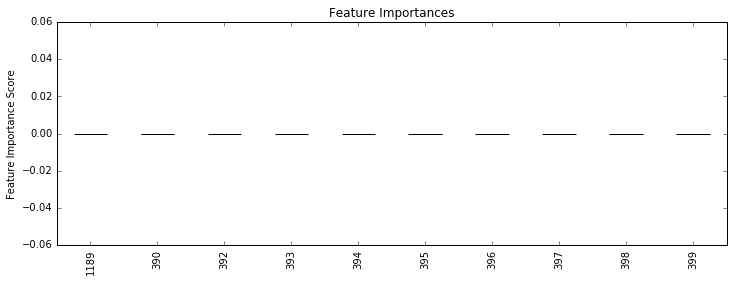

In [29]:
modelfit(model, X, Y, features)

### Parameter Tuning

#### number of estimators

In [5]:
estimators = {'n_estimators':list(range(20,81,10))}
model_params = {'learning_rate': 0.1, 'min_samples_split': 1800, 
                'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls'}

In [6]:
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=8,iid=False, cv=5)
gsearch1.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=1800, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [7]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -4731799.93858, std: 129147.48360, params: {'n_estimators': 20},
  mean: -4371664.74605, std: 122786.81896, params: {'n_estimators': 30},
  mean: -4167027.39796, std: 111633.96686, params: {'n_estimators': 40},
  mean: -4044960.91967, std: 113109.41987, params: {'n_estimators': 50},
  mean: -3967301.53674, std: 107416.26406, params: {'n_estimators': 60},
  mean: -3911997.48904, std: 106883.95238, params: {'n_estimators': 70},
  mean: -3875963.11726, std: 101597.08756, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 -3875963.1172550707)

The optimal estimators for 0.1 learning rate is 80, which is the maximum value in the range, this indicates that the optimal estimators could be higher than 80. 

In [6]:
estimators = {'n_estimators':list(range(80,300,20))}
model_params = {'learning_rate': 0.1, 'min_samples_split': 1800, 
                'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls'}

In [7]:
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=8,iid=False, cv=5)
gsearch2.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=1800, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'n_estimators': [80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [8]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -3875963.11726, std: 101597.08756, params: {'n_estimators': 80},
  mean: -3825573.78655, std: 102551.91998, params: {'n_estimators': 100},
  mean: -3791107.25022, std: 97494.51572, params: {'n_estimators': 120},
  mean: -3765542.23943, std: 93968.32078, params: {'n_estimators': 140},
  mean: -3742743.50992, std: 92719.69544, params: {'n_estimators': 160},
  mean: -3725148.23440, std: 93287.51090, params: {'n_estimators': 180},
  mean: -3711006.79774, std: 90642.60446, params: {'n_estimators': 200},
  mean: -3698696.61178, std: 87062.59275, params: {'n_estimators': 220},
  mean: -3689930.26089, std: 84383.18485, params: {'n_estimators': 240},
  mean: -3682321.02582, std: 81934.26823, params: {'n_estimators': 260},
  mean: -3675894.55675, std: 80645.05581, params: {'n_estimators': 280}],
 {'n_estimators': 280},
 -3675894.55674937)

In [4]:
best_estimators = 280

#### max_depth and min_samples_split

In [5]:
estimators = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(1000,1801,200))}
model_params = {'learning_rate': 0.1, 'min_samples_leaf': 50, 
                'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators}

In [6]:
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=2,iid=False, cv=5)
gsearch3.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=280, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=2,
       param_grid={'min_samples_split': [1000, 1200, 1400, 1600, 1800], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [7]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -3742221.44098, std: 82111.70451, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: -3751241.98247, std: 88602.93164, params: {'min_samples_split': 1200, 'max_depth': 5},
  mean: -3749850.47350, std: 90579.06344, params: {'min_samples_split': 1400, 'max_depth': 5},
  mean: -3745143.52502, std: 79563.03320, params: {'min_samples_split': 1600, 'max_depth': 5},
  mean: -3750020.28326, std: 78252.02084, params: {'min_samples_split': 1800, 'max_depth': 5},
  mean: -3668698.95514, std: 91717.86279, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: -3676810.30770, std: 86019.11401, params: {'min_samples_split': 1200, 'max_depth': 7},
  mean: -3678828.48914, std: 76650.62200, params: {'min_samples_split': 1400, 'max_depth': 7},
  mean: -3673236.70060, std: 82971.12898, params: {'min_samples_split': 1600, 'max_depth': 7},
  mean: -3688565.47400, std: 88669.43319, params: {'min_samples_split': 1800, 'max_depth': 7},
  mean: -3629789.04180, std: 79526.33954, params: 

In [9]:
best_max_depth = 15
best_min_samples_split = 1600

In [16]:
grid_parameters = {'min_samples_leaf': list(range(10, 31, 5))}
model_params = {'learning_rate': 0.1, 'subsample': 0.8,
                'max_features': 'sqrt', 'min_samples_split': best_min_samples_split,
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators, 'max_depth': best_max_depth}

In [17]:
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = grid_parameters, scoring='neg_mean_squared_error',n_jobs=2,iid=False, cv=5)
gsearch4.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=1600, min_weight_fraction_leaf=0.0,
             n_estimators=280, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=2,
       param_grid={'min_samples_leaf': [10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -3587471.39118, std: 79995.15042, params: {'min_samples_leaf': 10},
  mean: -3585248.96263, std: 59166.86427, params: {'min_samples_leaf': 15},
  mean: -3591248.28366, std: 80629.69610, params: {'min_samples_leaf': 20},
  mean: -3597103.95144, std: 61737.06569, params: {'min_samples_leaf': 25},
  mean: -3588238.26914, std: 72321.59689, params: {'min_samples_leaf': 30}],
 {'min_samples_leaf': 15},
 -3585248.962630873)

In [19]:
best_min_samples_leaf = 15

#### subsample

In [22]:
grid_parameters = {'subsample':[0.7,0.75,0.8,0.85,0.9]}
model_params = {'learning_rate': 0.1, 'min_samples_leaf': best_min_samples_split, 
                'max_features': 'sqrt', 'min_samples_split': best_min_samples_split,
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators, 'max_depth': best_max_depth}

In [23]:
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = grid_parameters, scoring='neg_mean_squared_error',n_jobs=2,iid=False, cv=5)
gsearch5.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1600,
             min_samples_split=1600, min_weight_fraction_leaf=0.0,
             n_estimators=280, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=2,
       param_grid={'subsample': [0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [24]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -3887814.22381, std: 104349.22889, params: {'subsample': 0.7},
  mean: -3866737.65764, std: 103289.66894, params: {'subsample': 0.75},
  mean: -3849626.18544, std: 101527.84397, params: {'subsample': 0.8},
  mean: -3840716.53971, std: 103012.58697, params: {'subsample': 0.85},
  mean: -3834767.41592, std: 110870.64621, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 -3834767.41591727)

In [25]:
best_subsample = 0.9

We have finished all the parameter tunning, the optimal values for each parameters are:

In [26]:
best_params = {'n_estimators': best_estimators, 
               'learning_rate': 0.1, 
               'min_samples_split': best_min_samples_split, 
               'min_samples_leaf': best_min_samples_leaf, 
               'max_depth': best_max_depth, 
               'max_features': 'sqrt', 
               'subsample': best_subsample, 
               'random_state': 10, 
               'loss': 'ls'}
best_model = GradientBoostingRegressor(**best_params)

Mean square error 3019103.9707495794
CV Score: Mean - 3592088.7547443868 | Std - 78456.600906637 | Min - 3484494.6497005303 | Max - 3711142.134075766


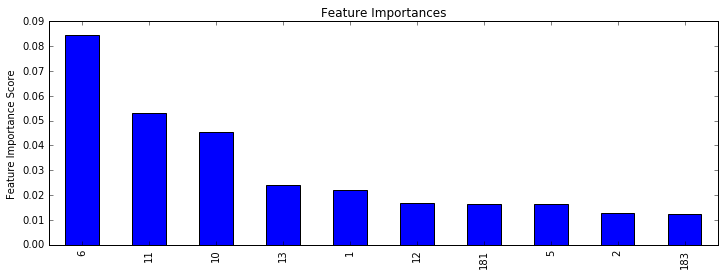

In [30]:
modelfit(best_model, X, Y, features)

Comparing this "best model" with the model we built based on intution.<br><br>
Old model:<br>
Mean square error 3842112.6796678584<br>
CV Score: Mean - 3952696.6976141683<br><br>

"Best model":<br>
Mean square error 3019103.9707495794<br>
CV Score: Mean - 3592088.7547443868 

### Test dataset

In [33]:
predictions = best_model.predict(test_data[features])

In [45]:
results = pd.Series(predictions, index=test_data['id'])
results = results.reset_index()
results.columns = ['id', 'loss']

In [47]:
results.to_csv('gbm_predictions_v2.csv')

#### Score: 1169

#### Reduce learning rate to 0.05 and increase n_estimators to 560

In [51]:
params_one = {'n_estimators': best_estimators * 2,  
               'learning_rate': 0.05, 
               'min_samples_split': best_min_samples_split, 
               'min_samples_leaf': best_min_samples_leaf, 
               'max_depth': best_max_depth, 
               'max_features': 'sqrt', 
               'subsample': best_subsample, 
               'random_state': 10, 
               'loss': 'ls'}
best_model_one = GradientBoostingRegressor(**params_one)

Mean square error 2979393.1947850753
CV Score: Mean - 3538901.539534764 | Std - 67792.35552240051 | Min - 3423845.398359565 | Max - 3621535.688940967


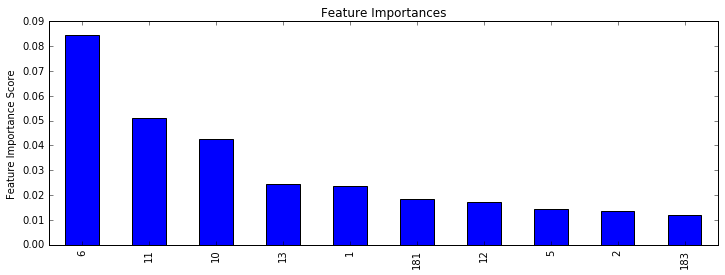

In [52]:
modelfit(best_model_one, X, Y, features)

#### Reduce learning rate to 0.01 and increase n_estimators to 2800

In [53]:
params_two = {'n_estimators': best_estimators * 10,  
               'learning_rate': 0.01, 
               'min_samples_split': best_min_samples_split, 
               'min_samples_leaf': best_min_samples_leaf, 
               'max_depth': best_max_depth, 
               'max_features': 'sqrt', 
               'subsample': best_subsample, 
               'random_state': 10, 
               'loss': 'ls'}
best_model_two = GradientBoostingRegressor(**params_two)

Mean square error 2948668.9837352196
CV Score: Mean - 3513137.126614137 | Std - 62024.59210627065 | Min - 3420284.9266948183 | Max - 3600945.7106511057


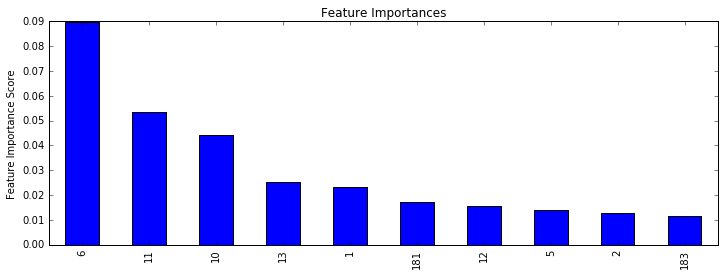

In [54]:
modelfit(best_model_two, X, Y, features)

In [55]:
predictions = best_model_two.predict(test_data[features])

In [56]:
results = pd.Series(predictions, index=test_data['id'])
results = results.reset_index()
results.columns = ['id', 'loss']

In [57]:
results.to_csv('gbm_predictions_v3.csv')

#### Score Private 1165.55141 Public 1156.19951